# Tutorial 3: How to select the best settings and advanced options
## flowTorch workshop 29.09.2025 - 02.10.2025

### Outline
1. Avoid large size differences between neighboring cells
2. Controlling the uniformity of the grid
3. Accelerating the refinement process for large *3D* datasets

In this tutorial, we will learn about how to avoid large size differences between neighboring cells as encounteered in the previous tutorial. Then we will look at some important parameters, which can be customized to control the topology of the grid. We will lastly see how we can use these parameters for large grids in combination with STL files for geometry objects.

In this tutorial we will again use the cylinder2D from the first tutorial since it is easy and fast to execute and available for everybody.

## 1. Avoid large size differences between neighboring cells
For some applications, e.g., when computing gradients or in case a good resolution of the geometry has to be ensured, large size differences between two neighboring cells may cause problems. We need to ensure smooth transitions within cell sizes across the grid in these cases. $S^3$ provides an additional argument, which can be set to ensure a max. level difference between two neighboring cells of one. The cell level refers here to the number of refinement we have to employ to get to this specific cell size.

To activate this criterion, we have to set `max_delta_level=True` when instantiating the `s_cube` object. This constraint will lead to smooth transitions, but also to longer execution times and mesh sizes, so it is recommended to only activate it when necessary.

In [1]:
import sys
import numpy as np
import torch as pt

from os.path import join
from os import environ, system

environ["sparseSpatialSampling"] = "../../.."
sys.path.insert(0, environ["sparseSpatialSampling"])

from sparseSpatialSampling.export import ExportData
from sparseSpatialSampling.sparse_spatial_sampling import SparseSpatialSampling
from sparseSpatialSampling.geometry import CubeGeometry, SphereGeometry
from sparseSpatialSampling.utils import load_foam_data

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
# define load paths to the CFD data
load_path = join("..", "..","..", "..", "flow_data", "run", "cylinder_2D_Re100")

# define the path to where we want to save the results and the name of the file
save_path = join("..","..", "..", "run", "tutorials", "tutorial_3")

# define boundaries of the masked domain for the cylinder, here we want to load the full domain
bounds = [[0, 0], [2.2, 0.41]]  # [[xmin, ymin], [xmax, ymax]]

# load the CFD data, we want to compute the metric based on the velocity in the quasi-steady state, so omit the first 8 seconds
field, coord, _, write_times = load_foam_data(load_path, bounds, field_name="U", t_start=8, scalar=False)

[2025-08-15 14:31:07] INFO     Loading precomputed cell centers and volumes from processor0/constant
[2025-08-15 14:31:07] INFO     Loading precomputed cell centers and volumes from processor1/constant


In [3]:
# now we compute a metric. in this case, we just use the temporal mean of the abs. velocity vector
metric = pt.mean(field.abs().sum(1), 1)

# create geometry objects for the domain and the cylinder
# we don't want to refine the domain boundaries, so keep all the optional arguments as default
domain = CubeGeometry("domain", True, bounds[0], bounds[1])

# we explicitly increase the resolution of the cylinder to cause large level differences when the constraint is not activated
geometry = SphereGeometry("cylinder", False, [0.2, 0.2], 0.05, refine=True, min_refinement_level=12)

In [4]:
# now we artificially create poor grid containing large level differences
s_cube = SparseSpatialSampling(coord, metric, [domain, geometry], save_path, "cylinder2D_nodeltaLevel_constraint", "cylinder2D", 
                               min_metric=0.5, n_jobs=4)
s_cube.execute_grid_generation()

# export only the last time step for demonstration purposes
export = ExportData(s_cube)
export.write_times = "10"
export.export(coord, field[:, :, -1].unsqueeze(-1), "U")

[2025-08-15 14:31:11] INFO     
	Selected settings:
		_pre_select          :	False
		_n_jobs              :	4
		_max_delta_level     :	False
		_geometry            :	['domain', 'cylinder']
		_min_metric          :	0.5
		_n_cells_max         :	None
		_min_level           :	5
		_cells_per_iter_start:	9
		_cells_per_iter_end  :	9
		_cells_per_iter      :	9
		_cells_per_iter_last :	1000000000.0
		_reach_at_least      :	0.75
		_n_dimensions        :	2
		_n_cells_orig        :	9800
		_relTol              :	0.001
[2025-08-15 14:31:11] INFO     Starting refinement:
	Starting iteration no. 0, N_cells = 1
	Starting iteration no. 1, N_cells = 4
	Starting iteration no. 2, N_cells = 8
	Starting iteration no. 3, N_cells = 16
	Starting iteration no. 4, N_cells = 64
[2025-08-15 14:31:16] INFO     Finished uniform refinement.
[2025-08-15 14:31:16] INFO     Starting adaptive refinement.
	Starting iteration no. 0, captured metric: 13.74 %, N_cells = 256
	Starting iteration no. 1, captured metric: 14.58 %

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


[2025-08-15 14:31:26] INFO     Finished refinement in 14.3668 s 
								(102 iterations).
								Time for uniform refinement: 4.9637 s
								Time for adaptive refinement: 4.3591 s
								Time for geometry refinement: 0.9209 s
								Time for renumbering the final mesh: 4.1085 s
								
                                    Number of cells: 4370
                                    Minimum ref. level: 5
                                    Maximum ref. level: 12
                                    Captured metric of original grid: 50.08 %
                  
[2025-08-15 14:31:26] INFO     Starting interpolation and export of field U.
[2025-08-15 14:31:26] INFO     Writing HDF5 file for field U.
[2025-08-15 14:31:26] INFO     Writing XDMF file for file cylinder2D_nodeltaLevel_constraint.h5
[2025-08-15 14:31:26] INFO     Finished export of field U in 0.104s.


In [5]:
# now we activate the max_delta_level constraint to see how the grid quality improves
s_cube = SparseSpatialSampling(coord, metric, [domain, geometry], save_path, "cylinder2D_deltaLevel_constraint", "cylinder2D", 
                               min_metric=0.5, n_jobs=4, max_delta_level=True)
s_cube.execute_grid_generation()

export = ExportData(s_cube)
export.write_times = "10"
export.export(coord, field[:, :, -1].unsqueeze(-1), "U")

[2025-08-15 14:31:26] INFO     
	Selected settings:
		_pre_select          :	False
		_n_jobs              :	4
		_max_delta_level     :	True
		_geometry            :	['domain', 'cylinder']
		_min_metric          :	0.5
		_n_cells_max         :	None
		_min_level           :	5
		_cells_per_iter_start:	9
		_cells_per_iter_end  :	9
		_cells_per_iter      :	9
		_cells_per_iter_last :	1000000000.0
		_reach_at_least      :	0.75
		_n_dimensions        :	2
		_n_cells_orig        :	9800
		_relTol              :	0.001
[2025-08-15 14:31:26] INFO     Starting refinement:
	Starting iteration no. 0, N_cells = 1
	Starting iteration no. 1, N_cells = 4
	Starting iteration no. 2, N_cells = 8
	Starting iteration no. 3, N_cells = 16
	Starting iteration no. 4, N_cells = 64
[2025-08-15 14:31:31] INFO     Finished uniform refinement.
[2025-08-15 14:31:31] INFO     Starting adaptive refinement.
	Starting iteration no. 0, captured metric: 13.74 %, N_cells = 256
	Starting iteration no. 1, captured metric: 14.58 %,

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


[2025-08-15 14:31:37] INFO     Writing HDF5 file for field U.
[2025-08-15 14:31:37] INFO     Writing XDMF file for file cylinder2D_deltaLevel_constraint.h5
[2025-08-15 14:31:37] INFO     Finished export of field U in 0.102s.


As already discussed in the introduction, we can see that the number of cells increased from $4370$ to $5820$ when activating the constraint. Now let's load the data into ParaView and compare the grids.

First we take a look at the grid without the constraint:

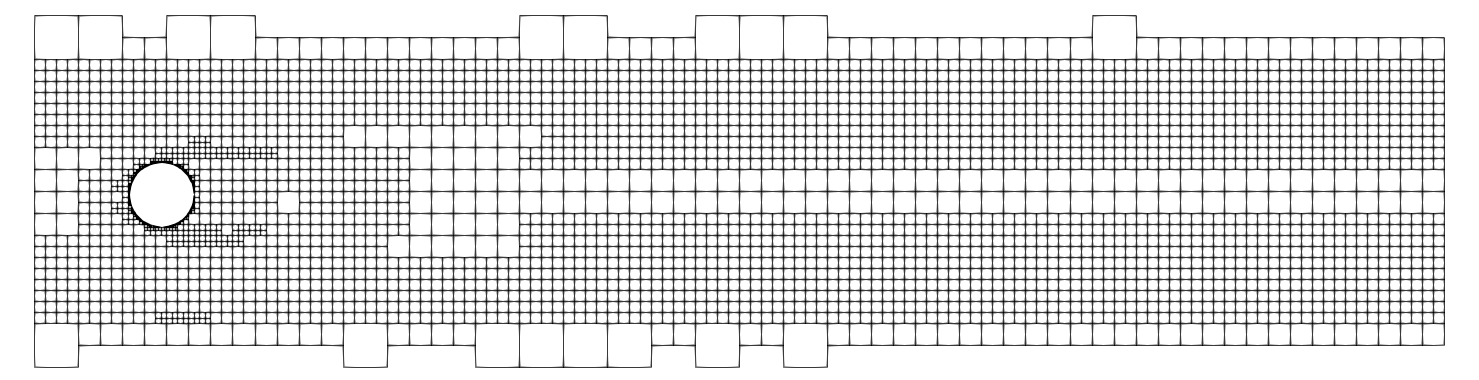

Here, we can already see large level differences at the domain boundaries and near the cylinder. We can zoom in the region near the cylinder to see it better: 

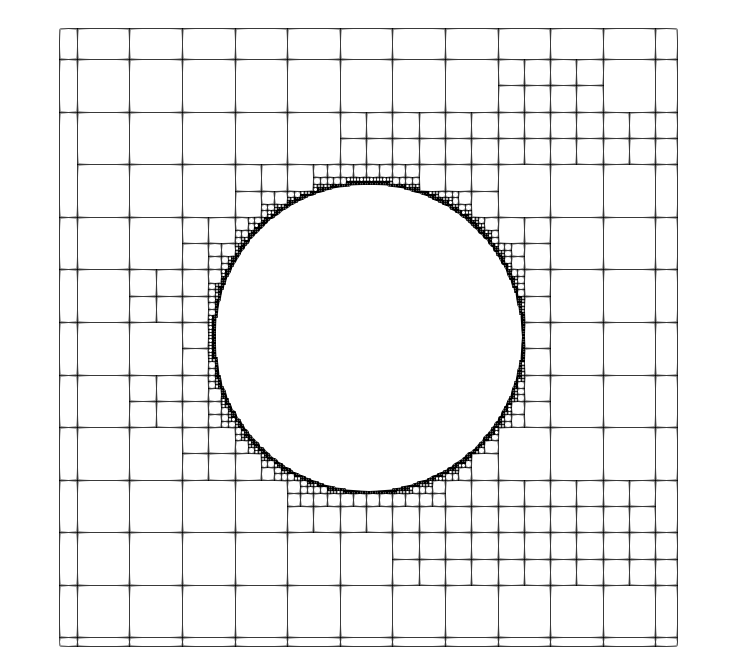

As explained, these differences within the cell size can cause problems, e.g. when computing gradients on that grid. As a comparison we can now take a look athe the grid which was created with the delta level constraint:

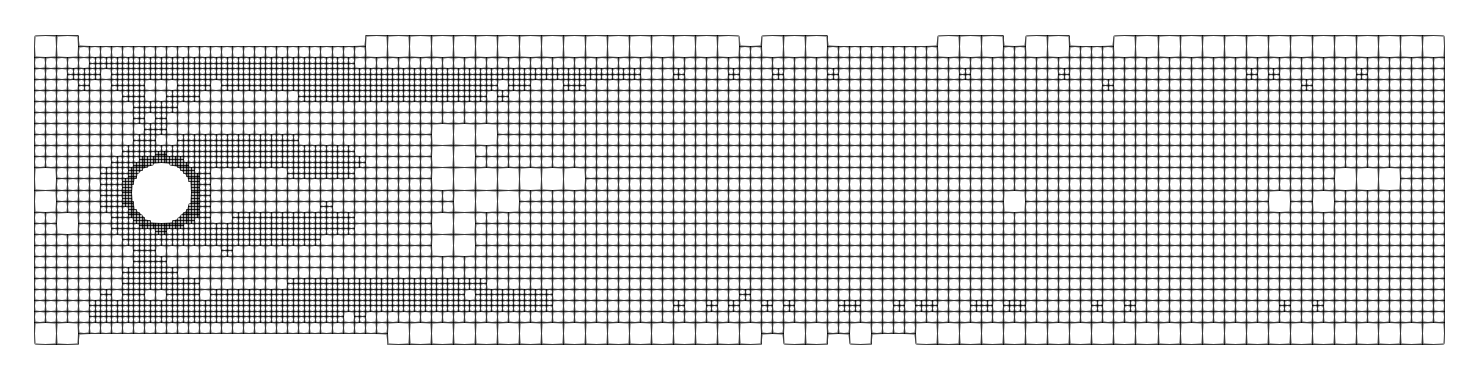

When we zoom in the same region as before we can see that the grid quality improved significantly:

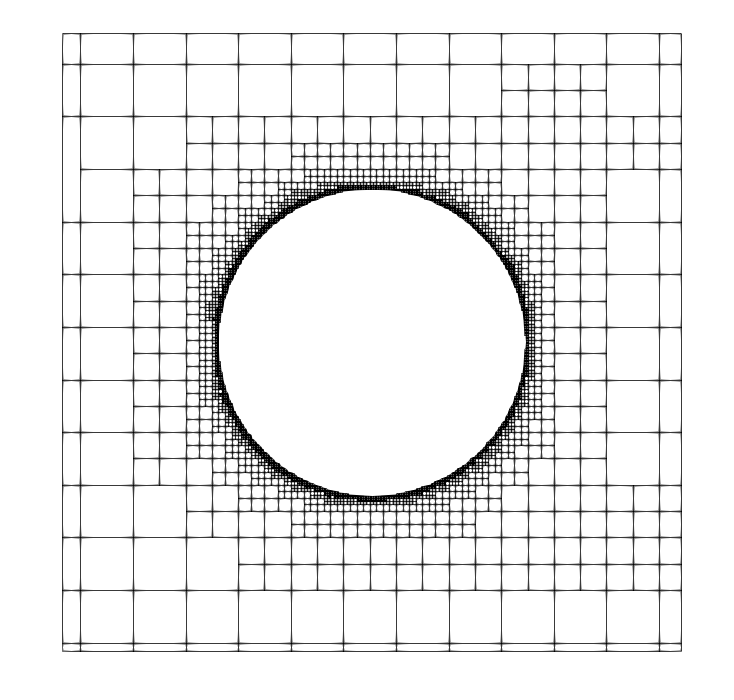

## 2. Controlling the uniformity of the grid
The next parameter we want to look at is `uniform_levels`, which controls the number of uniform grid levels. $S^3$ starts by creating a uniform background grid before starting the adaptive refinement in order to accelerate the grid generation process.

A rule of thumb is: when increasing the number uniform levels, the grid will become more uniform but the execution time decreases and vice versa. In general it is only sensible to adjust this parameter if the grid is expected to be very coarse (then `uniform_levels` has to be decreased), or if the number of grid levels is expected to be large. In the latter case, the number of uniform levels can be increased.

Since this parameter is quite intuitive, we will briefly show what happens if it gets increased in the following.

In [6]:
# execute for higher n_uniform levels
# The default is 5 uniform levels, but the min_level is already 6 so we don't expect the grid to be adaptive
s_cube = SparseSpatialSampling(coord, metric, [domain, geometry], save_path, "cylinder2D_6_uniform_levels", "cylinder2D", 
                               min_metric=0.5, n_jobs=4, uniform_levels=7)
s_cube.execute_grid_generation()

# export
export = ExportData(s_cube)
export.write_times = "10"
export.export(coord, field[:, :, -1].unsqueeze(-1), "U")

[2025-08-15 14:31:37] INFO     
	Selected settings:
		_pre_select          :	False
		_n_jobs              :	4
		_max_delta_level     :	False
		_geometry            :	['domain', 'cylinder']
		_min_metric          :	0.5
		_n_cells_max         :	None
		_min_level           :	7
		_cells_per_iter_start:	9
		_cells_per_iter_end  :	9
		_cells_per_iter      :	9
		_cells_per_iter_last :	1000000000.0
		_reach_at_least      :	0.75
		_n_dimensions        :	2
		_n_cells_orig        :	9800
		_relTol              :	0.001
[2025-08-15 14:31:37] INFO     Starting refinement:
	Starting iteration no. 0, N_cells = 1
	Starting iteration no. 1, N_cells = 4
	Starting iteration no. 2, N_cells = 8
	Starting iteration no. 3, N_cells = 16
	Starting iteration no. 4, N_cells = 64
	Starting iteration no. 5, N_cells = 256
	Starting iteration no. 6, N_cells = 894
[2025-08-15 14:31:43] INFO     Finished uniform refinement.
[2025-08-15 14:31:43] INFO     Starting adaptive refinement.
	Starting iteration no. 0, captured 

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


[2025-08-15 14:31:44] INFO     Writing HDF5 file for field U.
[2025-08-15 14:31:44] INFO     Writing XDMF file for file cylinder2D_6_uniform_levels.h5
[2025-08-15 14:31:44] INFO     Finished export of field U in 0.101s.


As we expected, the resulting grid is much more uniform than the grid using the default value of `uniform_levels=5`:

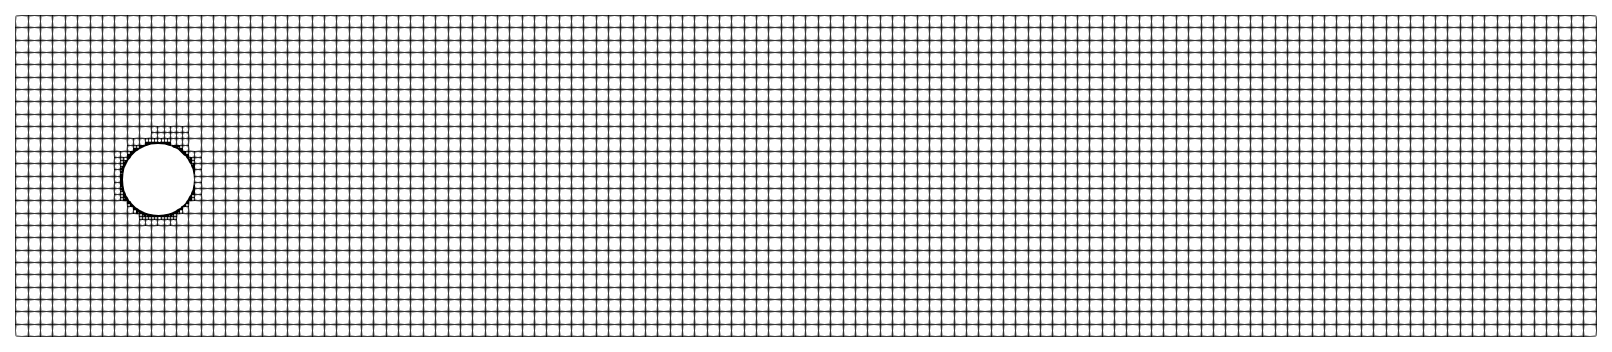

This happens because our grid using `uniform_levels=5` has a minimum refinement level of $6$. So if we increase `uniform_levels`to $7$ the adaptive refinement is never activated. 

## 3. Accelerating the refinement process for large *3D* datasets

For large grids and in case STL file(s) are used as geometry objects, there are three more parameters which we can adjust in order to accelerate the refienment process. However, since our cylinder2D test case is too simple to see an actual effect, we will just explain the usage of these parameters briefly in the following. 

The first two parameters are `n_cells_iter_start` and `n_cells_iter_end`. These parameters control how many cells are generated each iteration. By default `n_cells_iter_start=0.001 n_cells_original_grid` with `n_cells_original_grid` denoting the number of cells in the mesh from the simulation  and `n_cells_iter_end = n_cells_iter_start`. Each iteration, the number of cells to refine is computed based on properties of the current grid.

When increasing `n_cells_iter_start` and/or `n_cells_iter_end`, this leads to generating more cells per iteration and therefore a more uniform grid. Decreasing them analogously leads to a more adaptive grid, however, it also increases the runtime of $S^3$. In general, these parameters have a more complex influence on the runtime and resulting grid than, e.g., `uniform_levels`, so usually it should be avoided to modify them. But it may be helpful in some special cases. 

The last parameter is `pre_select`, which is useful when STL files are used as geometry objects. Especially if the expected number of grid points is large and the STL file has a high resolution (contains many points). To accelerate the grid generation, the class `GeometrySTL3D` provides an additional parameter `reduce_by`, which compresses the STL file by $x\%$. The optimal compression ratio depends on the application, but values up to `reduce_by=0.9` generally shouldn't cause any problems.
If that is still not able to decrease the required runtime significantly, the parameter `pre_select`can be set to `True` when instantiating the `s_cube` object. Since this parameter determines possible cells in the vicinity of the geometry much faster than the 'standard' way when dealing with STL files, this can significantly accelerate the refinement process.

**Note:** The parameter `pre_select` works best if the edges of a box drawn around the STL file have nearly the same length, meaning that the shape of the STL file is nearly cubic. For STL files which have a dominant length, e.g. aircraft with high aspect ratio wings, setting `pre_select=True` may even increase the required runtime!

This concludes the third tutorial. The next tutorial presents different options when exporting the data to HDF5. 